In [2]:
# load modules

import os
import numpy as np 
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

from pysersic.results import plot_image
from pysersic import check_input_data
from pysersic.priors import SourceProperties
from pysersic.priors import autoprior
from pysersic import FitSingle
from pysersic.loss import student_t_loss_free_sys
from pysersic.results import plot_residual
from pysersic.rendering import HybridRenderer
from pysersic.multiband import FitMultiBandPoly

import jax
import jax.numpy as jnp
from jax.random import (
    PRNGKey,  # Need to use a seed to start jax's random number generation
)

#import sep

from pysersic.loss import student_t_loss

import corner 

import asdf

import arviz as az

from sedpy import observate 

from astropy.modeling.models import Sersic1D
from astropy.visualization import make_lupton_rgb
from astropy.cosmology import Planck18 as cosmo



d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# define path
path_wdir = r"D:\Programming\Cambridge\Enso Data"
path_fig = os.path.join(path_wdir, '191250_')

# define filter list
filter_list = ["f090w", "f115w", "f150w", "f182m", "f200w", "f210m", "f277w", "f356w", "f410m", "f444w"]
filterlist = observate.load_filters(["jwst_" + f for f in filter_list])


# integrated photometry
# mag_integrated = np.array([25.567, 24.299, 22.826, 22.154, 21.827, 21.616, 21.546])  # ??

# define redshift
redshift = 5.3
pix_scale = 0.03  # from .fits header
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(redshift).value/60
# print rest-wavelength
# print(np.array([filterlist[1:][ii].wave_effective/1e4 for ii in range(len(band_list))])/(1+redshift))    #name 'band_list' is not defined



In [4]:
# check wlengths and create custom band list as alternative to full filter list
filterlist[0].wave_effective

np.float64(8982.436421837761)

In [5]:
band_list = filter_list[:]
wv_list = np.array([filterlist[:][ii].wave_effective/1e4 for ii in range(len(band_list))])
wv_list

array([0.89824364, 1.14859202, 1.49442228, 1.84236203, 1.97811383,
       2.09374694, 2.76120868, 3.54834844, 4.07932817, 4.37878307])

In [6]:
wv_list/(1+redshift)

array([0.14257836, 0.18231619, 0.23720989, 0.29243842, 0.31398632,
       0.33234078, 0.43828709, 0.56322991, 0.64751241, 0.69504493])

In [7]:
def load_data(filter, plot=False):

    '''
    Loading the data
    
    The 4 needed inputs to perform a fit are
     - im: the image itself
     - mask: a mask indicating pixels which should not be included in the fit
     - sig: a map of pixel uncertainties 
     - psf: a map of the PSF (for now, only one psf can be used).
    '''

    # load image data
    fname = os.path.join(path_wdir, '191250_cutouts', '191250_' + filter.upper() + '.fits')
    im = fits.getdata(fname, 'SCI')
    wht = fits.getdata(fname, 'WHT')
    ycen, xcen = 100, 100
    im = im[xcen-22:xcen+28, ycen-25:ycen+25]
    wht = wht[xcen-22:xcen+28, ycen-25:ycen+25]
    mask = np.zeros(im.shape)
    sig = 0.01/np.sqrt(np.abs(wht)) + 0.1*np.sqrt(np.abs(im))
    sig = 0.1*np.sqrt(np.abs(im))
    header = fits.getheader(fname, 'SCI')
    
    # load the PSF data
    PSF_large = fits.getdata(os.path.join(path_wdir, 'mpsf_gds', 'mpsf_' + filter.lower() + '.fits'))
    cen = int(0.5*PSF_large.shape[0])
    psf = PSF_large[cen-18:cen+19, cen-18:cen+19]
    psf /= np.sum(psf)
    psf = psf.astype(float)

    if plot:
        # plot data
        fig, ax = plot_image(im, mask, sig, psf)
        plt.show()

    # check data
    if check_input_data(data=im, rms=sig, psf=psf, mask=mask):
        print("data looks good!")
    else:
        print("data looks bad!")

    return(im, mask, sig, psf)




In [14]:
# test on single filter
im, mask, sig, psf = load_data(filter='f090w')
from pysersic.results import plot_image
from pysersic.priors import autoprior

prior = autoprior(image=im, profile_type="sersic_exp", mask=mask, sky_type="none")
prior
# fig, ax = plot_image(im, mask, sig, psf)

data looks good!


Prior for a sersic_exp source:
------------------------------
flux ---  Normal w/ mu = 13.03, sigma = 7.22
xc ---  Normal w/ mu = 24.56, sigma = 1.00
yc ---  Normal w/ mu = 21.42, sigma = 1.00
f_1 ---  Uniform between: 0.00 -> 1.00
theta ---  Uniform between: 0.00 -> 6.28
r_eff_1 ---  Truncated Normal w/ mu = 4.63, sigma = 2.15, between: 0.50 -> inf
r_eff_2 ---  Truncated Normal w/ mu = 10.41, sigma = 3.23, between: 0.50 -> inf
ellip_1 ---  Uniform between: 0.00 -> 0.90
ellip_2 ---  Uniform between: 0.00 -> 0.90
n ---  Truncated Normal w/ mu = 4.00, sigma = 1.00, between: 0.65 -> 8.00
sky type - None

"FitMultiBandPoly"  uses a polynomial to “link” the parameters across wavelength.  
Next we must decide which parameters we want to be ‘linked’. For these parameters pysersic will parameterize them with a polynomial as a function of wavelength.

## Multi-band, single & double component

In [15]:

psf_dict = {}
img_dict = {}
rms_dict = {}
prior_dict = {}
prior_2comp_dict = {}

# iterate through filters/bands, compiling dicts of psf, img, rms, and 1-/2-comp priors
# for each band
for j,band in enumerate(band_list):
    # load data
    im, mask, sig, psf = load_data(filter=band)
    psf_dict[band] = psf
    img_dict[band] = im
    rms_dict[band] = sig
    # SourceProperties analyses the source image to determine properties
    props = SourceProperties(im, mask=mask) # Optional mask
    # generate prior 1 - single component
    prior = props.generate_prior('sersic', # Other profiles inclues 'exp', 'dev' and 'pointsource'
                          sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background    
    # fix the sersic index prior between 0.5 and 4.5
    # prior.set_uniform_prior('n', 0.5, 4.5)
    prior_dict[band] = prior # store the prior for that band

    # generate prior 2: - 2-component: fixed sersic bulge, exponential disk
    prior = props.generate_prior('sersic_exp', # Other profiles inclues 'exp', 'dev' and 'pointsource'
                          sky_type='none') # Can also use 'flat' or 'tilted-plane' to simultaneously fit a background    
    # prior.set_uniform_prior('r_eff_1', 0.5, 5.0)
    # prior.set_uniform_prior('r_eff_2', 10.0, 20.0)
    # prior.set_uniform_prior('n', 0.5, 4.5)  # Sersic index of the central component
    print(prior)

    prior_2comp_dict[band] = prior # store the 2comp prior for that band


data looks good!
Prior for a sersic_exp source:
------------------------------
flux ---  Normal w/ mu = 13.03, sigma = 7.22
xc ---  Normal w/ mu = 24.56, sigma = 1.00
yc ---  Normal w/ mu = 21.42, sigma = 1.00
f_1 ---  Uniform between: 0.00 -> 1.00
theta ---  Uniform between: 0.00 -> 6.28
r_eff_1 ---  Truncated Normal w/ mu = 4.63, sigma = 2.15, between: 0.50 -> inf
r_eff_2 ---  Truncated Normal w/ mu = 10.41, sigma = 3.23, between: 0.50 -> inf
ellip_1 ---  Uniform between: 0.00 -> 0.90
ellip_2 ---  Uniform between: 0.00 -> 0.90
n ---  Truncated Normal w/ mu = 4.00, sigma = 1.00, between: 0.65 -> 8.00
sky type - None

data looks good!
Prior for a sersic_exp source:
------------------------------
flux ---  Normal w/ mu = 25.92, sigma = 10.18
xc ---  Normal w/ mu = 24.29, sigma = 1.00
yc ---  Normal w/ mu = 21.71, sigma = 1.00
f_1 ---  Uniform between: 0.00 -> 1.00
theta ---  Uniform between: 0.00 -> 6.28
r_eff_1 ---  Truncated Normal w/ mu = 5.70, sigma = 2.39, between: 0.50 -> inf
r_ef

In [16]:

# loop through and run fit in each of the 3 bands
fitter_dict = {}
ind_res_dict = {}
fitter2_dict = {}
ind2_res_dict = {}
rkey = jax.random.PRNGKey(19)
for band in band_list:
    rkey,_ = jax.random.split(rkey, 2) # use differeny random number key for each run
    # save single source fitter to fitter_cur variable for this band
    fitter_cur = FitSingle(
        data=img_dict[band],
        rms = rms_dict[band],
        psf = psf_dict[band],
        prior = prior_dict[band],
        mask = mask.copy(),
        loss_func = student_t_loss_free_sys
    )
    print (f'Running fit - {band}') 
    ind_res_cur = fitter_cur.estimate_posterior(rkey = rkey)  # run the fit
    ind_res_dict[band] = ind_res_cur.retrieve_med_std()
    fitter_dict[band] = fitter_cur # create a dictionary of fitters for each band
    
    # repeated with 2-component prior
    fitter_cur = FitSingle(
        data=img_dict[band],
        rms = rms_dict[band],
        psf = psf_dict[band],
        prior = prior_2comp_dict[band],
        mask = mask.copy(),
        loss_func = student_t_loss_free_sys
    )
    print (f'Running fit - {band}')
    ind_res_cur = fitter_cur.estimate_posterior(rkey = rkey)
    ind2_res_dict[band] = ind_res_cur.retrieve_med_std()
    fitter2_dict[band] = fitter_cur




d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f090w


  1%|▏         | 251/20000 [00:00<00:24, 797.78it/s, Round = 2,step_size = 5.0e-04 loss: -9.434e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f090w


  1%|▏         | 256/20000 [00:00<00:46, 420.70it/s, Round = 2,step_size = 5.0e-04 loss: -9.425e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f115w


  1%|▏         | 251/20000 [00:00<00:27, 722.49it/s, Round = 2,step_size = 5.0e-04 loss: -9.031e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f115w


  1%|▏         | 252/20000 [00:00<00:42, 461.27it/s, Round = 2,step_size = 5.0e-04 loss: -9.030e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f150w


  1%|▏         | 254/20000 [00:00<00:25, 778.12it/s, Round = 2,step_size = 5.0e-04 loss: -9.026e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f150w


  1%|▏         | 263/20000 [00:00<01:06, 296.12it/s, Round = 2,step_size = 5.0e-04 loss: -9.028e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f182m


  1%|▏         | 257/20000 [00:00<00:23, 850.08it/s, Round = 2,step_size = 5.0e-04 loss: -8.568e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f182m


  2%|▏         | 302/20000 [00:00<00:36, 537.05it/s, Round = 2,step_size = 5.0e-04 loss: -8.566e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f200w


  1%|▏         | 251/20000 [00:00<00:31, 630.84it/s, Round = 2,step_size = 5.0e-04 loss: -8.895e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f200w


  1%|▏         | 251/20000 [00:00<00:44, 446.01it/s, Round = 2,step_size = 5.0e-04 loss: -8.894e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f210m


  1%|▏         | 268/20000 [00:00<00:25, 765.11it/s, Round = 2,step_size = 5.0e-04 loss: -8.176e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f210m


  2%|▏         | 352/20000 [00:00<00:35, 554.39it/s, Round = 2,step_size = 5.0e-04 loss: -8.176e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f277w


  1%|▏         | 282/20000 [00:00<00:40, 487.09it/s, Round = 2,step_size = 5.0e-04 loss: -8.145e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f277w


  1%|▏         | 255/20000 [00:00<00:56, 350.08it/s, Round = 2,step_size = 5.0e-04 loss: -8.163e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f356w


  1%|▏         | 251/20000 [00:00<00:33, 584.79it/s, Round = 2,step_size = 5.0e-04 loss: -7.895e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f356w


  1%|▏         | 252/20000 [00:00<00:38, 511.71it/s, Round = 2,step_size = 5.0e-04 loss: -7.915e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f410m


  1%|▏         | 251/20000 [00:00<00:28, 689.40it/s, Round = 2,step_size = 5.0e-04 loss: -7.276e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f410m


  1%|▏         | 251/20000 [00:00<00:41, 479.22it/s, Round = 2,step_size = 5.0e-04 loss: -7.306e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f444w


  2%|▏         | 407/20000 [00:00<00:27, 720.50it/s, Round = 2,step_size = 5.0e-04 loss: -7.393e+03]
d:\Programs\anaconda3\envs\pysersic\Lib\site-packages\pysersic\pysersic.py:75: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  self.renderer = renderer(data.shape, self.psf, **renderer_kwargs)


Running fit - f444w


  1%|▏         | 283/20000 [00:00<00:43, 454.20it/s, Round = 2,step_size = 5.0e-04 loss: -7.420e+03]


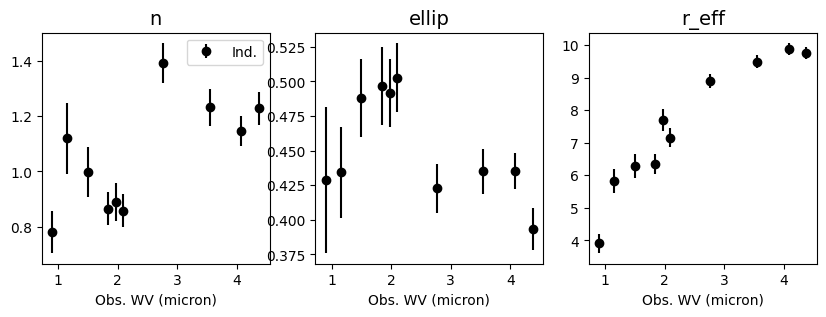

In [17]:
# Plot single comp fits to check
fig, axes = plt.subplots(1,3, figsize = (10,3))

for j,param in enumerate(['n','ellip','r_eff']):
    ax = axes[j]

    med_ind = [ind_res_dict[b][param][0] for b in band_list]
    err_ind = [ind_res_dict[b][param][1] for b in band_list]
    ax.errorbar(wv_list, med_ind, yerr=err_ind, fmt = 'o', color = 'k', label = 'Ind.')
    ax.set_xlabel('Obs. WV (micron)')
    ax.set_title(param, fontsize = 14)
axes[0].legend()

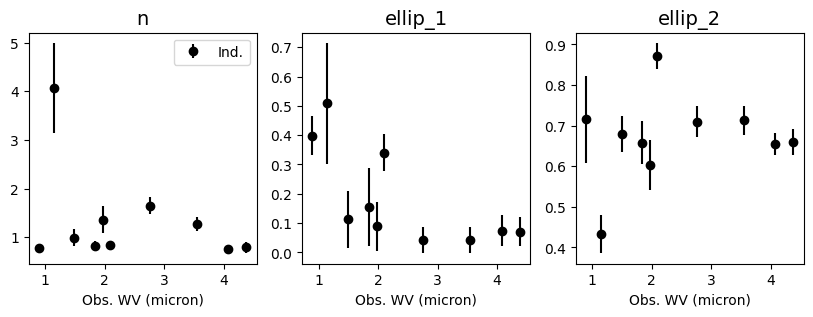

In [27]:
fig, axes = plt.subplots(1,3, figsize = (10,3))

#, 'r_eff_1', 'r_eff_2'

for j,param in enumerate(['n','ellip_1', 'ellip_2']):
    ax = axes[j]

    med_ind = [ind2_res_dict[b][param][0] for b in band_list]
    err_ind = [ind2_res_dict[b][param][1] for b in band_list]
    ax.errorbar(wv_list, med_ind, yerr=err_ind, fmt = 'o', color = 'k', label = 'Ind.')
    ax.set_xlabel('Obs. WV (micron)')
    ax.set_title(param, fontsize = 14)
axes[0].legend()

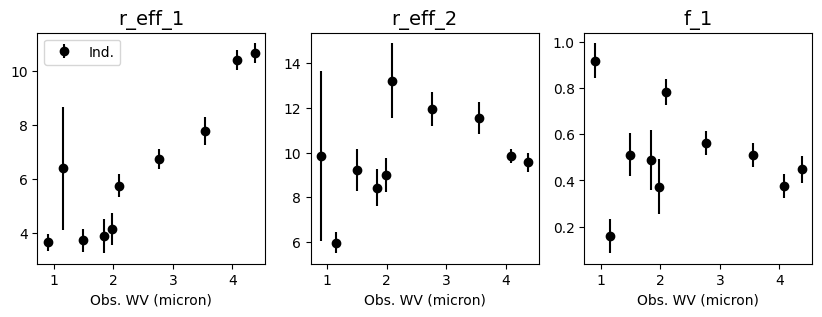

In [29]:
fig, axes = plt.subplots(1,3, figsize = (10,3))

for j,param in enumerate(['r_eff_1', 'r_eff_2', 'f_1']):
    ax = axes[j]

    med_ind = [ind2_res_dict[b][param][0] for b in band_list]
    err_ind = [ind2_res_dict[b][param][1] for b in band_list]
    ax.errorbar(wv_list, med_ind, yerr=err_ind, fmt = 'o', color = 'k', label = 'Ind.')
    ax.set_xlabel('Obs. WV (micron)')
    ax.set_title(param, fontsize = 14)
axes[0].legend()

##### Multiband fitting

In [30]:
wv_to_save = np.linspace(min(wv_list),max(wv_list), num = 50)

# single component
MultiFitter = FitMultiBandPoly(fitter_list=[fitter_dict[b] for b in band_list],
                               wavelengths=wv_list,
                               band_names= band_list,
                               linked_params=['n','ellip','r_eff'],
                               const_params=['xc','yc','theta'],
                               wv_to_save= wv_to_save,
                               poly_order = 2)
rkey,_ = jax.random.split(rkey,2)
multires = MultiFitter.estimate_posterior(method = 'svi-flow', rkey = rkey)

link_params = [f'{param}_{b}' for b in band_list for param in ['r_eff','n','ellip']] # Look at posteriors of "linked" parameters
multi_res_dict = multires.retrieve_med_std()
az.summary(multires.idata, var_names=link_params)



  6%|▌         | 1223/20000 [01:08<17:36, 17.77it/s, Round = 2,step_size = 5.0e-04 loss: -8.371e+04]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r_eff_f090w,4.480,0.188,4.144,4.825,0.006,0.004,1066.0,804.0,NaN
n_f090w,0.845,0.047,0.763,0.931,0.001,0.001,1086.0,996.0,NaN
ellip_f090w,0.440,0.023,0.400,0.482,0.001,0.000,1073.0,878.0,NaN
r_eff_f115w,5.166,0.148,4.908,5.447,0.005,0.003,1049.0,905.0,NaN
n_f115w,0.888,0.046,0.809,0.975,0.001,0.001,1079.0,1071.0,NaN
ellip_f115w,0.447,0.018,0.415,0.481,0.001,0.000,1087.0,929.0,NaN
r_eff_f150w,6.039,0.115,5.846,6.269,0.004,0.003,1010.0,880.0,NaN
n_f150w,0.953,0.042,0.873,1.027,0.001,0.001,1049.0,1011.0,NaN
ellip_f150w,0.454,0.013,0.431,0.480,0.000,0.000,1098.0,916.0,NaN
r_eff_f182m,6.831,0.106,6.636,7.027,0.003,0.002,956.0,813.0,NaN


<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
C:\Users\kings\AppData\Local\Temp\ipykernel_5312\3511838424.py:48: SyntaxWarning: invalid escape sequence '\m'
  plt.savefig(path_wdir + '\multi_1comp.pdf', bbox_inches='tight')


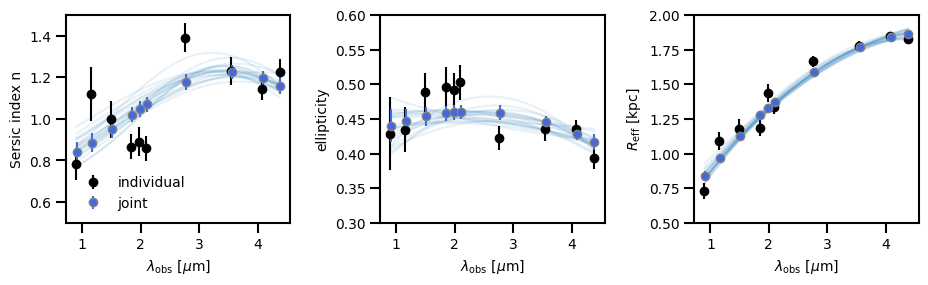

In [31]:
# plot results 

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(11, 2.7))

titles = ["Sersic index n", "ellipticity", r"$R_{\rm eff}$ [kpc]"]


for j, param in enumerate(['n','ellip','r_eff']):
    ax = axes[j]

    med_ind = np.array([ind_res_dict[b][param][0] for b in band_list])
    err_ind = np.array([ind_res_dict[b][param][1] for b in band_list])

    med_multi = np.array([multi_res_dict[f'{param}_{b}'][0] for b in band_list])
    err_multi = np.array([multi_res_dict[f'{param}_{b}'][1] for b in band_list])

    if (param == 'r_eff'):
        conversion = kpc_per_arcsec*pix_scale
    else:
        conversion = 1.0
    
    param_smooth = multires.idata.posterior[f'{param}_at_wv'].data.squeeze()
    ax.plot(wv_to_save, conversion*param_smooth[:20].T, '-', color='C0', alpha = 0.1)
    ax.errorbar(wv_list, conversion*med_ind, yerr=conversion*err_ind, fmt = 'o', color = 'k', label = 'individual')
    ax.errorbar(wv_list+0.01, conversion*med_multi, yerr=conversion*err_multi, fmt = 'o', color = 'royalblue', markeredgecolor='gray', label = 'joint')
    # ax.plot(1/wv_to_save, conversion*param_smooth[:20].T, '-', color='crimson', alpha = 0.1)
    # ax.errorbar(1/wv_list, conversion*med_ind, yerr=conversion*err_ind, fmt = 'o', color = 'k', label = 'individual')
    # ax.errorbar(1/wv_list+0.01, conversion*med_multi, yerr=conversion*err_multi, fmt = 'o', color = 'crimson', markeredgecolor='gray', label = 'joint')
    # ax.set_title(param, fontsize = 14)
    ax.set_xlabel(r'$\lambda_{\rm obs}$ [$\mu$m]')
    # ax.set_xlim([1, 5])
    ax.set_ylabel(titles[j])

axes[0].set_ylim([0.5, 1.5])
axes[1].set_ylim([0.3, 0.6])
axes[2].set_ylim([0.5, 2])
axes[0].legend(frameon=False)

axes[0].tick_params(width=1.5, length=7)
plt.setp(axes[0].spines.values(), lw=1.5)
axes[1].tick_params(width=1.5, length=7)
plt.setp(axes[1].spines.values(), lw=1.5)
axes[2].tick_params(width=1.5, length=7)
plt.setp(axes[2].spines.values(), lw=1.5)
# fig.suptitle('Multi-band fitting, single component', fontsize=16, y=1.05)

plt.subplots_adjust(wspace=0.4, hspace=0.05)
plt.savefig(path_wdir + '\multi_1comp.pdf', bbox_inches='tight')
plt.show()


Here, prior is 0.5 > n > 4.5, which seems fine as none touch those bounds.

In [32]:
# extract best fit and save

ind_fit = {}
joint_fit = {}
ind_err_fit = {}
joint_err_fit = {}

for j,param in enumerate(['flux', 'n', 'ellip', 'r_eff']):

    ind_fit[param] = [ind_res_dict[b][param][0] for b in band_list]
    ind_err_fit[param] = [ind_res_dict[b][param][1] for b in band_list]

    joint_fit[param] = [multi_res_dict[f'{param}_{b}'][0] for b in band_list]
    joint_err_fit[param] = [multi_res_dict[f'{param}_{b}'][1] for b in band_list]


TO RENDER, AND PLOT RESIDUALS, YOU NEED A DICTIONARY OF THE PARAMETERS (MEAN).
CURRENTLY, MULTIBAND RESULTS ARE IN "MULTIRES"

In [13]:
# print("Keys in multi_res_dict:", multi_res_dict.keys())


In [14]:
# multi_res_dict['n_poly_coeff']
# multi_res_dict['n_f090w']

In [15]:
# from pysersic.rendering import HybridRenderer

# def render_multiband_fits(MultiFitter, multires, band_list):
#     fig, axes = plt.subplots(len(band_list), 1, figsize=(12, 6 * len(band_list)))
    
#     for i, band in enumerate(band_list):
#         ax = axes[i]
        
#         # Extract the model parameters for the current band
#         params = multi_res_dict
#         model_params = {
#             'xc': params['xc'][0],
#             'yc': params['yc'][0],
#             'r_eff': params[f'r_eff_{band}'][0],
#             'n': params['n'][0],
#             'ellip': params['ellip'][0],
#             'flux': params[f'flux_{band}'][0],
#             'theta': params['theta'][0]
#         }
        
#         # Render the model for the current band
#         im = MultiFitter.fitter_list[i].data
#         psf = MultiFitter.fitter_list[i].psf
#         mask = MultiFitter.fitter_list[i].mask
#         renderer = HybridRenderer(im.shape, jnp.array(psf.astype(np.float32)))
#         bf_model = renderer.render_sersic(**model_params)
        
#         # Plot the residuals
#         fig, ax = plot_residual(im, bf_model, mask=mask, vmin=-1, vmax=1, ax=ax)
#         ax.set_title(f'Multiband Fit Residuals - {band}')
    
#     plt.tight_layout()
#     plt.show()

# # Call the function to render and plot the fits
# render_multiband_fits(MultiFitter, multires, band_list)

In [16]:
# ?
param = 'ellip'
conv = 1.0 #kpc_per_arcsec*pix_scale
print(conv*np.round(ind_fit[param],2), conv*np.round(ind_err_fit[param],2))
print(conv*np.round(joint_fit[param],2), conv*np.round(joint_err_fit[param],2))


[0.43 0.43 0.49 0.5  0.49 0.5  0.42 0.43 0.44 0.39] [0.05 0.03 0.03 0.03 0.02 0.02 0.02 0.02 0.01 0.01]
[0.44 0.45 0.45 0.46 0.46 0.46 0.46 0.44 0.43 0.42] [0.02 0.02 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]


### Double Component

In [ ]:
wv_to_save = np.linspace(min(wv_list),max(wv_list), num = 50)

# double component
MultiFitter = FitMultiBandPoly(fitter_list=[fitter2_dict[b] for b in band_list],
                               wavelengths=wv_list,
                               band_names= band_list,
                               linked_params=['f_1'],
                               const_params=['xc','yc','theta','r_eff_1','ellip_1','r_eff_2','ellip_2'],
                               wv_to_save= wv_to_save,
                               poly_order = 2)
rkey,_ = jax.random.split(rkey,2)
multires = MultiFitter.estimate_posterior(method = 'svi-flow', rkey = rkey)

link_params = [f'{param}_{b}' for b in band_list for param in ['f_1']] # Look at posteriors of "linked" parameters
multi2_res_dict = multires.retrieve_med_std()
az.summary(multires.idata, var_names=link_params)


  6%|▌         | 1176/20000 [01:26<23:08, 13.55it/s, Round = 2,step_size = 5.0e-04 loss: -8.370e+04] 
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f_1_f090w,1.502,0.062,1.388,1.619,0.002,0.001,1113.0,778.0,NaN
f_1_f115w,1.366,0.053,1.267,1.469,0.002,0.001,1117.0,865.0,NaN
f_1_f150w,1.190,0.044,1.115,1.280,0.001,0.001,1101.0,843.0,NaN
f_1_f182m,1.029,0.037,0.961,1.100,0.001,0.001,1032.0,1026.0,NaN
f_1_f200w,0.970,0.036,0.905,1.039,0.001,0.001,1000.0,1070.0,NaN
f_1_f210m,0.922,0.035,0.860,0.990,0.001,0.001,977.0,1070.0,NaN
f_1_f277w,0.677,0.033,0.616,0.737,0.001,0.001,891.0,847.0,NaN
f_1_f356w,0.462,0.033,0.404,0.523,0.001,0.001,922.0,869.0,NaN
f_1_f410m,0.361,0.035,0.300,0.424,0.001,0.001,982.0,952.0,NaN
f_1_f444w,0.320,0.038,0.255,0.392,0.001,0.001,1035.0,942.0,NaN


In [34]:
az.summary(multires.idata, var_names=['n', 'r_eff_1','r_eff_2'])


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
n,1.121,0.046,1.044,1.206,0.001,0.001,940.0,937.0,NaN
r_eff_1,7.064,0.155,6.749,7.318,0.005,0.004,855.0,901.0,NaN
r_eff_2,11.656,0.228,11.238,12.074,0.007,0.005,1033.0,994.0,NaN


In [35]:
# print("1st Comp (bulge) Re:", 4.899*kpc_per_arcsec*pix_scale, "+/-", 0.082*kpc_per_arcsec*pix_scale)
# print("2nd Comp (disc) Re:", 10.421*kpc_per_arcsec*pix_scale, "+/-", 0.117*kpc_per_arcsec*pix_scale)

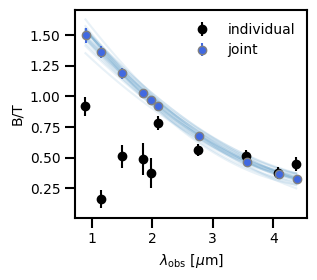

In [36]:
titles = ["B/T"]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 2.7))

for j, param in enumerate(['f_1']):
    ax = axes

    med_ind = np.array([ind2_res_dict[b][param][0] for b in band_list])
    err_ind = np.array([ind2_res_dict[b][param][1] for b in band_list])

    med_multi = np.array([multi2_res_dict[f'{param}_{b}'][0] for b in band_list])
    err_multi = np.array([multi2_res_dict[f'{param}_{b}'][1] for b in band_list])

    if (param == 'r_eff_1') | (param == 'r_eff_2'):
        conversion = kpc_per_arcsec*pix_scale
    else:
        conversion = 1.0
    
    param_smooth = multires.idata.posterior[f'{param}_at_wv'].data.squeeze()
    ax.plot(wv_to_save, conversion*param_smooth[:20].T, '-', color='C0', alpha = 0.1)
    ax.errorbar(wv_list, conversion*med_ind, yerr=conversion*err_ind, fmt = 'o', color = 'k', label = 'individual')
    ax.errorbar(wv_list+0.01, conversion*med_multi, yerr=conversion*err_multi, fmt = 'o', color = 'royalblue', markeredgecolor='gray', label = 'joint')
    # ax.set_title(param, fontsize = 14)
    ax.set_xlabel(r'$\lambda_{\rm obs}$ [$\mu$m]')
    # ax.set_xlim([1, 5])
    ax.set_ylabel(titles[j])

# axes.set_ylim([0.0, 1])
axes.legend(frameon=False)

axes.tick_params(width=1.5, length=7)
plt.setp(axes.spines.values(), lw=1.5)
# plt.title('Multi-band fitting, double component', pad = 15)

# plt.subplots_adjust(wspace=0.8, hspace=0.07)
# plt.savefig(path_wdir + '\multi_2comp.pdf', bbox_inches='tight')
plt.show()


In [21]:
# extract best fit and save

ind2_fit = {}
joint2_fit = {}
ind2_err_fit = {}
joint2_err_fit = {}

for j,param in enumerate(['f_1', 'flux']):

    ind2_fit[param] = [ind2_res_dict[b][param][0] for b in band_list]
    ind2_err_fit[param] = [ind2_res_dict[b][param][1] for b in band_list]

    joint2_fit[param] = [multi2_res_dict[f'{param}_{b}'][0] for b in band_list]
    joint2_err_fit[param] = [multi2_res_dict[f'{param}_{b}'][1] for b in band_list]

